<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week3_FluvialIncision/Part3_SanGabrielMountains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Channel steepness analysis of the San Gabriel Mountains, California



*This lesson has been written Fiona Clubb at Durham University, based on an original notebook by Simon M. Mudd at the University of Edinburgh*

Now we've had a look at some channel profiles and the stream power incision model, we are going to try to extract some channel profiles from a real landscape and explore how channel steepness varies across the landscape. You should be able to modify this notebook for different areas for use in your independent project, if you like.

We are going to be using the San Gabriel Mountains, California, as an example. Channel steepness has been found to increase non-linearly with erosion rates in this landscape (DiBiase et al., 2010). It would be helpful if you had a look at this paper before doing the practical:


---

*DiBiase, R.A., Whipple, K.X., Heimsath, A.M. and Ouimet, W.B., 2010. Landscape form and millennial erosion rates in the San Gabriel Mountains, CA. Earth and Planetary Science Letters, 289(1-2), pp.134-144. https://doi.org/10.1016/j.epsl.2009.10.036*

---



We're going to use a python package called `lsdviztools` to download a digital elevation model (DEM) with a resolution of 30 m. This is from the Shuttle Radar Topography Mission (SRTM): this DEM is available pretty much globally, so it's very useful for this module and potentially for your dissertation project.

We also will do a little bit of topographic analysis using **lsdtopotools**. **lsdtopotools** is a software package for analysing topography developed at the University of Edinburgh, Durham University, and other institutions. 

## Get the right python packages

In this first cell we're going to install `lsdtopotools` and `lsdviztools`. 
**WARNING - the first time you do this, it might take up to 5 minutes. Just wait for it to finish and then you don't have to run it again for the rest of the practical (even if you need to restart the kernel).**



In [2]:
!pip install lsdviztools &> /dev/null


First we download miniconda, which takes about 30 seconds.

In [2]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.8.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT &> /dev/null
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed


                                                                                                   
UnsatisfiableError: The following specifications were found to be incompatible with each other:

Output in format: Requested package -> Available versions

Package libgcc-ng conflicts for:
requests==2.22.0=py37_1 -> python[version='>=3.7,<3.8.0a0'] -> libgcc-ng[version='>=7.3.0|>=9.3.0']
libgdal -> cfitsio[version='>=3.470,<3.471.0a0'] -> libgcc-ng[version='>=7.3.0|>=7.5.0|>=9.3.0']
xorg-renderproto -> libgcc-ng[version='>=9.3.0']
ruamel_yaml==0.15.87=py37h7b6447c_0 -> libgcc-ng[version='>=7.3.0']
pthread-stubs -> libgcc-ng[version='>=7.5.0']
sqlite==3.31.1=h7b6447c_0 -> libgcc-ng[version='>=7.3.0']
libpng -> libgcc-ng[version='>=7.5.0']
hdf5 -> openssl[version='>=1.1.1i,<1.1.2a'] -> libgcc-ng[version='>=7.3.0|>=9.4.0|>=7.5.0']
libzip -> openssl[version='>=1.1.1k,<1.1.2a'] -> libgcc-ng[version='>=7.3.0|>=9.4.0|>=7.5.0']
libglib -> libgcc-ng[version='>=9.4.0']
reproc -> libgcc-ng[version=


The next step is to set the conda channels, install mamba (because it installs lsdtopotools much faster than conda) and then finally lsdtopotools. This takes ~3.5 minutes.

In [4]:
!conda config --add channels conda-forge &> /dev/null
!conda config --set channel_priority strict &> /dev/null
!conda install -c conda-forge -y mamba &> /dev/null
!mamba install -c conda-forge -y lsdtopotools &> /dev/null

In [3]:
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw
import pandas as pd
import geopandas as gpd
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

## Now grab some data

First, we need to grab some data. We use a tool in `lsdviztools.lsdbasemaptools` called the `ot_scraper` (`ot` is for opentopography.org).

You can tell this what sort of data you want (most people will use the SRTM 30 metre data) and you also tell it the lower left and the upper right corners, using latitude and longitude. You can get these from goole earth by right clicking on the map and selecting "what's here". In this example below, I will just get a small area near Sorbas. But you might expand your search area. 

In [4]:
# If you want to modify the DEM, change the bounding latitude and longitude. Change the `Dataset_prefix` if you want to change the name of the output DEM.
Dataset_prefix = "San_Gabriel"
SG_DEM = bmt.ot_scraper(source = "SRTM30",longitude_W = -118.257749, longitude_E = -117.488604, 
                            latitude_S = 34.143650, latitude_N =  34.404547,prefix = Dataset_prefix)
SG_DEM.print_parameters()
SG_DEM.download_pythonic()

The source is: SRTMGL1
The west longitude is: -118.257749
The east longitude is: -117.488604
The south latitude is: 34.404547
The north latitude is: 34.14365
The path is: ./
The prefix is: San_Gabriel
The resolution is: 30
I am going to download the following for you:
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=34.14365&north=34.404547&west=-118.257749&east=-117.488604&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
The filename will be:
./San_Gabriel_SRTMGL1.tif
The path and file without path are:
./  San_Gabriel_SRTMGL1.tif
Finished downloading


('./San_Gabriel_SRTMGL1.tif', './', 'San_Gabriel_SRTMGL1.tif')

That just downloaded a .tif file, which you can find in the "Files" tab in Google Colab. If you like you can download it and look at in a GIS. 
You can also look at the raw data here in python using something called `rasterio`. 

But we will use some tools called **lsdtopotools** to look at the data. 

To do that, we need to convert the data into a format **lsdtopotools** can understand. 

The option below uses something called GDAL (short for Geospatial Data Abstraction Library). 
It has many tools for converting raster data formats and changing projections. It is also fast: it is much faster to convert or merge files using gdal than in, say, ArcMap. QGIS has the gdal tools built in. You can read more here: https://lsdtopotools.github.io/LSDTT_documentation/LSDTT_introduction_to_geospatial_data.html#translating-your-raster-into-something-that-can-be-used-by-lsdtopotoolbox

In the below line the main thing you would change is the zone: this is the UTM zone. You can look up your UTM zone here: http://www.dmap.co.uk/utmworld.htm

In [22]:
import subprocess

# Below is the resolution of your data in metres
res = "30"

# Change the below UTM zone to the correct zone for your dataset
pr = "+proj=utm +zone=10 +datum=WGS84"

# Dont change the stuff below this line
gd = "gdalwarp"
sr = "-t_srs"
of = "-of"
en = "ENVI"
ov = "-overwrite"
tr = "-tr"
r = "-r"
rm = "cubic"
infile = Dataset_prefix+"_SRTMGL1.tif"
outfile = Dataset_prefix+"_SRTMGL1_UTM.bil"

subprocess_list = [gd, sr, pr, of, en, ov, tr, res, res, r, rm, infile, outfile]

subprocess.run(subprocess_list)

# Below is the gdalwarp call that is not used but is here for future reference
#!gdalwarp -t_srs '+proj=utm +zone=30 +datum=WGS84' -of ENVI -overwrite Sorbas_SRTM30.tif Sorbas_SRTM30_UTM.bil

CompletedProcess(args=['gdalwarp', '-t_srs', '+proj=utm +zone=10 +datum=WGS84', '-of', 'ENVI', '-overwrite', '-tr', '30', '30', '-r', 'cubic', 'San_Gabriel_SRTMGL1.tif', 'San_Gabriel_SRTMGL1_UTM.bil'], returncode=0)

## Now we do some topographic analysis and look at the data

We will extract some topogaphic metrics using `lsdtopotools`, which we installed earlier in the notebook.

The `lsdtt_parameters` are the various parametes that you can use to run an analysis. We will discuss these later. For now, we will just follow this recipe. 

In [23]:
lsdtt_parameters = {"write_hillshade" : "true",  
                    "surface_fitting_radius" : "60",
                    "print_slope" : "true"}
r_prefix = Dataset_prefix+"_SRTMGL1_UTM"
w_prefix = Dataset_prefix+"_SRTMGL1_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()


The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: San_Gabriel_SRTMGL1_UTM
The write prefix is: San_Gabriel_SRTMGL1_UTM
The parameter dictionary is:
{'write_hillshade': 'true', 'surface_fitting_radius': '60', 'print_slope': 'true'}


In [24]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


That will take a little while to run (wait until there is a number in brackets beside the `In` to the right of the cell.)

It will spit out some files. If you want to see what files are in this directory after the cell has finished you can run the following cell:

In [13]:
!ls

Miniconda3-py37_4.8.2-Linux-x86_64.sh
sample_data
San_Gabriel_SRTMGL1.tif
San_Gabriel_SRTMGL1_UTM.bil
San_Gabriel_SRTMGL1_UTM.bil.aux.xml
San_Gabriel_SRTMGL1_UTM.hdr
San_Gabriel_SRTMGL1_UTM_hs.bil
San_Gabriel_SRTMGL1_UTM_hs.hdr
San_Gabriel_SRTMGL1_UTM_ingestedParam.param
San_Gabriel_SRTMGL1_UTM_SLOPE.bil
San_Gabriel_SRTMGL1_UTM_SLOPE.hdr
Test_01.driver


You will see that we have made some new rasters. We have made
* *San_Gabriel_SRTMGL1_UTM_hs*: a hillshade
* *San_Gabriel_SRTMGL1_UTM_SLOPE*: a slope raster


## Exercise 1

* Download the hillshade and the slope raster (each one is made of two files: one ending in `.bil` and one ending in `.hdr`. Open QGIS or ArcGIS and load the rasters (drag the `.bil` file into the window).

* Make a shaded slope map of the study area: to do this, load in both files and make sure the slope map is the top layer. Give the slope a transparency, say 50%, so you can see the hillshade through it. 


## Get some channel profiles

Okay, we will now run a different analysis which will allow us to get channel profiles for a range of drainage basins in the region.

In [28]:
lsdtt_parameters = {"print_basin_raster" : "true",
                    "print_chi_data_maps" : "true",
                    "minimum_basin_size_pixels" : "5000"}
r_prefix = Dataset_prefix+"_SRTMGL1_UTM"
w_prefix = Dataset_prefix+"_SRTMGL1_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: San_Gabriel_SRTMGL1_UTM
The write prefix is: San_Gabriel_SRTMGL1_UTM
The parameter dictionary is:
{'print_basin_raster': 'true', 'print_chi_data_maps': 'true', 'minimum_basin_size_pixels': '5000'}


In [29]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


If you look at the files that we have created, you'll see that a number of new files now exist: The new files we've created are:

Now we are going to read in the channel data using geopandas. 

After this finishes running it will produce a csv file. 

These csv files can be read here, in the python environment. But they can also be loaded into a GIS by importing text data. You can make a file that is immediatly readable using a GIS by adding the option `convert_csv_to_geojson` to the parameters, so the command two cells up would become:

    lsdtt_parameters = {"print_basin_raster" : "true",
                        "print_chi_data_maps" : "true",
                        "convert_csv_to_geojson" : "true",
                        "minimum_basin_size_pixels" : "5000"}
                        
The disadvantage of this is that geojson files are much larger than csv. And you really only use these files with a GIS: if you use python you will be using the csv file. 

Okay, the cells below load a csv file using first `pandas` and then converts it into `geopandas` (which is `pandas` with georeferencing). 

The above routines print some data about the channels, and it also prints the basin information. The basins have different numbers. You can see where they are with this command: 

Basin keys are: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
I'm going to make the basin plots. Your topographic data must be in ENVI bil format or I'll break!!
Your colourbar will be located: None
xsize: 2412 and y size: 1085
NoData is: -32768.0
Yoyoyoyo the EPSG is :EPSG:32610
EPSG:32610
The EPSGString is: EPSG:32610
minimum values are x: 936015.0 and y: 3788264.0
I made the ticks.
x labels are: 
['940', '950', '960', '970', '980', '990', '1000']
x locations are:
[940000.0, 950000.0, 960000.0, 970000.0, 980000.0, 990000.0, 1000000.0]
y labels are: 
['3790', '3800', '3810', '3820']
y locations are:
[3790000.0, 3800000.0, 3810000.0, 3820000.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
San_Gabriel_SRTMGL1_UTM_AllBasins.bil
Let me grab the coordinate reference system.
EPSG:32610
Whoops. Found a repeated ID. Getting rid of the smaller one.
Found a repeated ID.

<Figure size 432x288 with 0 Axes>

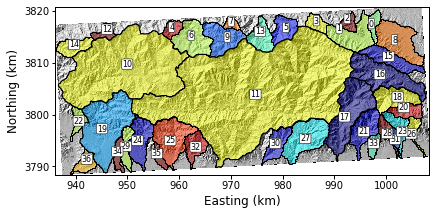

In [31]:
DataDirectory = "./"
Base_file = Dataset_prefix+"_SRTMGL1_UTM"
basin_img = lsdmw.PrintBasins_Complex(DataDirectory,Base_file,
                                        use_keys_not_junctions = True, 
                                        show_colourbar = False,cmap = "jet", 
                                        colorbarlabel = "colourbar", size_format = "geomorphology",
                                        fig_format = "png", dpi = 250, 
                                        include_channels = False, label_basins = True,
                                        save_fig=False)

In [32]:
chi_data_map_name = w_prefix+"_chi_data_map.csv"
df = pd.read_csv(chi_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

    latitude   longitude  ...  basin_key                     geometry
0  34.358962 -117.588918  ...          0  POINT (-117.58892 34.35896)
1  34.359246 -117.589226  ...          0  POINT (-117.58923 34.35925)
2  34.359515 -117.589209  ...          0  POINT (-117.58921 34.35952)
3  34.359799 -117.589516  ...          0  POINT (-117.58952 34.35980)
4  34.360083 -117.589823  ...          0  POINT (-117.58982 34.36008)

[5 rows x 9 columns]


In [33]:
bounds = gdf.total_bounds
print(bounds)

[-118.257578    34.1438519 -117.48888     34.4045367]


We will plot these data on a map using something called cartopy. 

If you want to plot only one basin uncomment line 26 and select a basin.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
plt.rcParams['figure.figsize'] = [10, 10]

stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([bounds[0]-0.2, bounds[2]+0.2, bounds[1]-0.1, bounds[3]+0.1], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 11.
ax.add_image(stamen_terrain, 11)

# Add the channel data
gdf2 = gdf.to_crs(epsg=3857)    # We have to convert the data to the same 
                               #system as the ap tiles. It happens to be this one. 
                               # This epsg code is used for all map tiles (like google maps)

# IF YOU WANT TO PLOT ONE BASIN, UNCOMMENT THE LINE BELOW        
#gdf2 = gdf2[(gdf2['basin_key'] == 5)]

gdf2.plot(ax=ax, markersize=0.5, column='chi', zorder=10,cmap="jet")

Geometry must be a Point or LineString


Now to plot the channels in profile

In [1]:
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
chi = gdf_b2.chi

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(x_locs, z,s = 0.2)
ax2.scatter(chi, z,s = 0.2)


ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("elevation (m)")

ax2.set_xlabel("$\chi$ ($m$)")
ax2.set_ylabel("elevation (m)")

plt.tight_layout()

NameError: ignored

## Getting the full channel profile with steepness information

In lesson 2, we are going to work with a file that has the extension `_MChiSegmented.csv`. 
To generate this file, you need to run the following command.

**Warning**: This is quite computationally expensive so if you have a big area it will take a while for this routine to finish. 

If you want to play with this data in a GIS, you would change line 2 of the cell below to:

    lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                        "print_basin_raster" : "true",
                        "convert_csv_to_geojson" : "true"}

In [ ]:
command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true"}

r_prefix = Dataset_prefix+"_SRTM30_UTM"
w_prefix = Dataset_prefix+"_SRTM30_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

We can use the `!ls` command to see if the file is there (the `!` tells the notebook to access the underlying linux operating system, and `ls` is a linux command that lists (`ls` is short for list) the contents of the current directory).

In [ ]:
!ls

Okay, the data is there, it is called `SorbasChi_MC_MChiSegmented.csv`. Lets load it with `geopandas`.

In [ ]:
segmented_data_map_name = w_prefix+"_MChiSegmented.csv"
df = pd.read_csv(segmented_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

Lets plot the points

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
plt.rcParams['figure.figsize'] = [10, 10]


bounds = gdf.total_bounds
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure()

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([bounds[0]-0.05, bounds[2]+0.05, bounds[1]-0.05, bounds[3]+0.05], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 11.
ax.add_image(stamen_terrain, 11)

# Add the channel data
gdf2 = gdf.to_crs(epsg=3857)    # We have to convert the data to the same 
                               #system as the ap tiles. It happens to be this one. 
                               # This epsg code is used for all map tiles (like google maps)

# IF YOU WANT TO PLOT ONE BASIN, UNCOMMENT THE LINE BELOW        
#gdf2 = gdf2[(gdf2['basin_key'] == 0)]
gdf2.plot(ax=ax, markersize=0.5, column='m_chi', zorder=10,cmap="jet")